## Imports

In [1]:
import numpy as np
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from bbtoolkit.preprocessing.environment import EnvironmentBuilder, Object2D, Point2D

## Build Environment

#### Initialize Environment Builder

In [2]:
min_xy, max_xy = -20, 20 # create the box of size 20x20
min_train_x, max_train_x, min_train_y, max_train_y = -20, 20, -20, 0 # create the training area of size 20x10
res = 0.3 # set grid resolution

builder = EnvironmentBuilder(
    min_xy,
    max_xy,
    (min_train_x, min_train_y),
    (max_train_x, max_train_y),
    res=res
)

### Visualize Environment layout

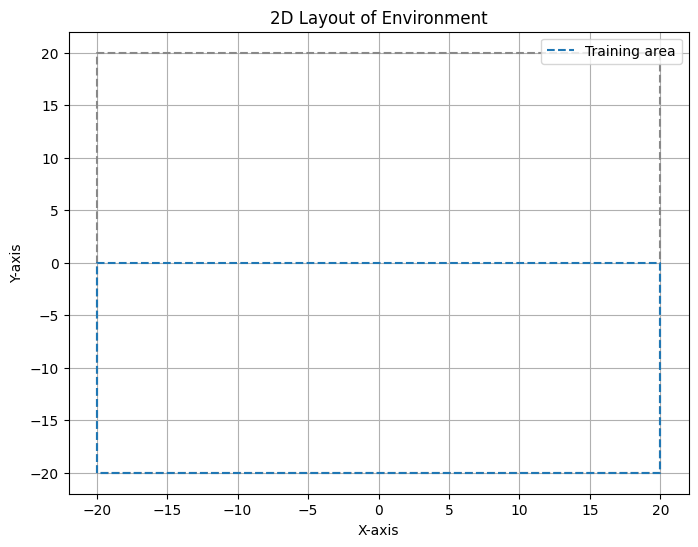

In [3]:
fig = builder.plot()

### Add object

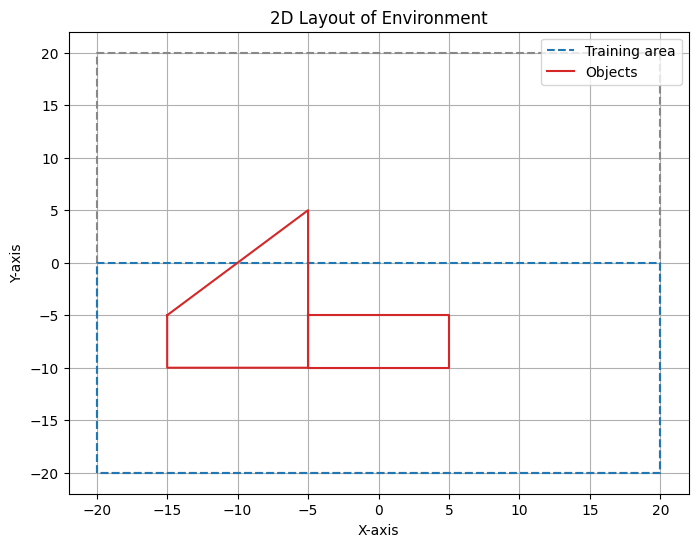

In [4]:
builder = EnvironmentBuilder(
    min_xy,
    max_xy,
    (min_train_x, min_train_y),
    (max_train_x, max_train_y),
    res=res
)

fig = builder.add_object(
    Object2D(
        # Note: last point should be the same as the first one to close the polygon. If not, it will be added automatically
        Point2D(-15, -5),
        Point2D(-15, -10),
        Point2D(-5, -10),
        Point2D(-5, 5),
    ),
    # Another object
    Object2D(
        Point2D(-5, -5),
        Point2D(-5, -10),
        Point2D(5, -10),
        Point2D(5, -5),
    ),
).plot()

### Remove object

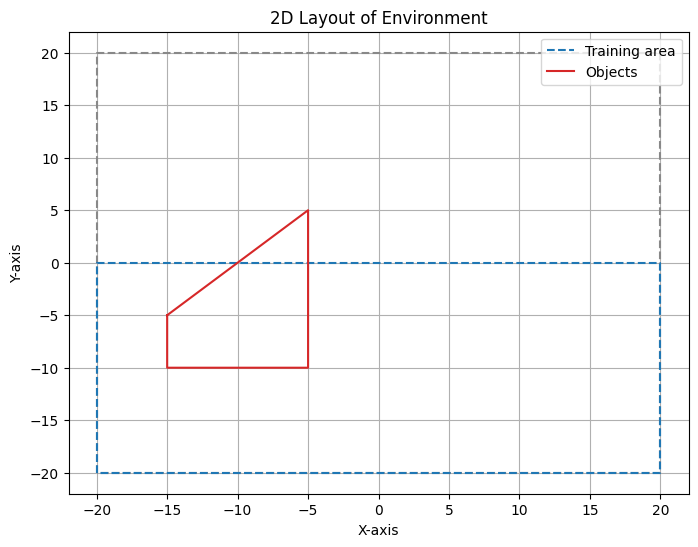

In [5]:
fig = builder.remove_object(1).plot()

### Modify object

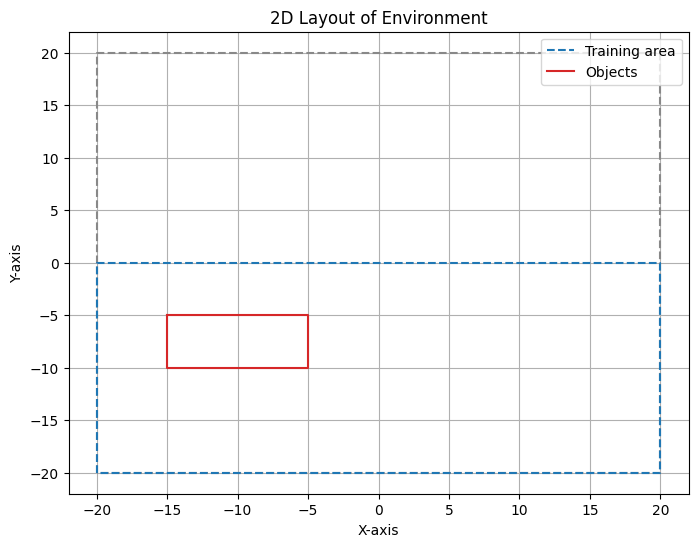

In [6]:
object_ = builder[0]
object_[-1] = Point2D(-5, -5) # Technically, -1 refers to the n-1 point, because the last point is the same as the first one to close the polygon
fig = builder.plot()

### Make some environment

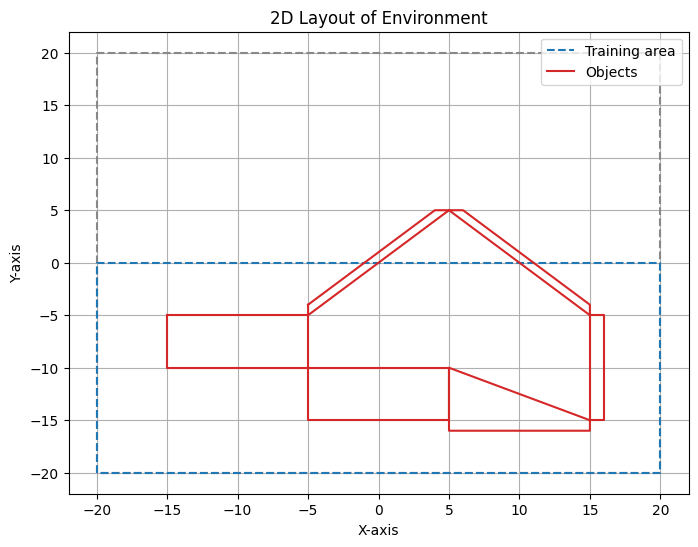

In [7]:
fig = builder.add_object(
    Object2D(
        Point2D(-5, -4),
        Point2D(4, 5),
        Point2D(5, 5),
        Point2D(-5, -5)
    ),
    Object2D(
        Point2D(5, 5),
        Point2D(6, 5),
        Point2D(15, -4),
        Point2D(15, -5)
    ),
    Object2D(
        Point2D(15, -5),
        Point2D(16, -5),
        Point2D(16, -15),
        Point2D(15, -15)
    ),
    Object2D(
        Point2D(15, -15),
        Point2D(15, -16),
        Point2D(5, -16),
        Point2D(5, -10)
    ),
    Object2D(
        Point2D(5, -10),
        Point2D(5, -15),
        Point2D(-5, -15),
        Point2D(-5, -10)
    )
).plot()

## Save environment

In [8]:
builder.save('environment.ini')

### .ini file

```ini
[ExternalSources]
paths = 
variables = 

[GridBoundaries]
max_xy = 20
min_xy = -20
res = 0.3

[TrainingRectangle]
min_train_x = -20
min_train_y = -20
max_train_x = 20
max_train_y = 0

[BuildingBoundaries]
max_n_obj_points = 5
n_objects = 6
n_polygons = 6
n_textures = 6

[Object1]
n_vertices = 5
object_x = -15, -15, -5, -5, -15
object_y = -5, -10, -10, -5, -5

[Object2]
n_vertices = 5
object_x = -5, 4, 5, -5, -5
object_y = -4, 5, 5, -5, -4

[Object3]
n_vertices = 5
object_x = 5, 6, 15, 15, 5
object_y = 5, 5, -4, -5, 5

[Object4]
n_vertices = 5
object_x = 15, 16, 16, 15, 15
object_y = -5, -5, -15, -15, -5

[Object5]
n_vertices = 5
object_x = 15, 15, 5, 5, 15
object_y = -15, -16, -16, -10, -15

[Object6]
n_vertices = 5
object_x = 5, 5, -5, -5, 5
object_y = -10, -15, -15, -10, -10

```

## Load environment

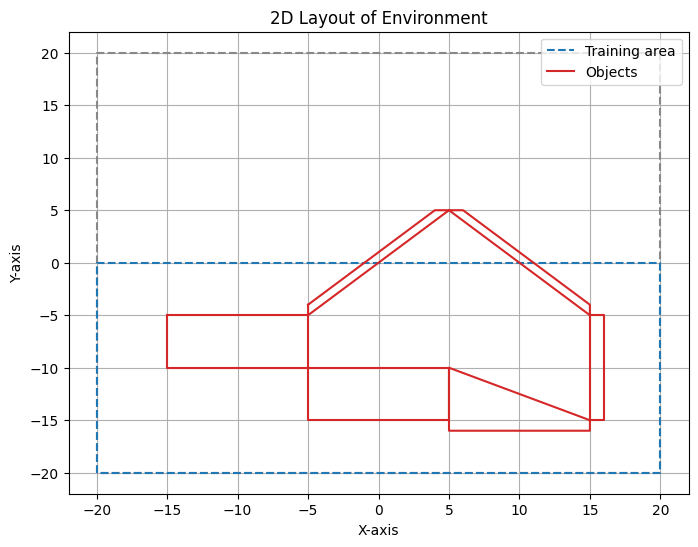

In [9]:
builder = EnvironmentBuilder.load('environment.ini')
fig = builder.plot()

## Compile environment

In [10]:
geometry = builder.build()()

### Check training space

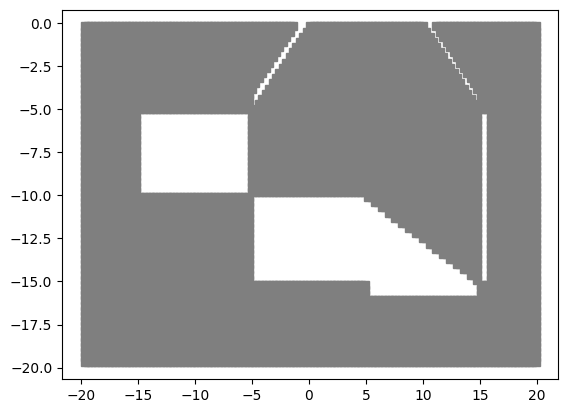

In [11]:
fig = geometry.training_space.plot()

## Circular environment

### Function to create coordinates for bagel-shaped polygon

In [ ]:
def generate_bagel_polygon(outer_radius: int, inner_radius: int, num_points: int, center: tuple[int, int] = (0, 0)):
    """
    Generate coordinates for a bagel-shaped polygon.

    Args:
        outer_radius (int): The radius of the outer circle.
        inner_radius (int): The radius of the inner circle.
        num_points (int): The number of points used to create the circular polygon.
        center (tuple[int, int], optional): The center coordinates of the bagel. Defaults to (0, 0).

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing the X and Y coordinates of the bagel-shaped polygon.

    Example:
        >>> outer_radius = 8
        >>> inner_radius = 4
        >>> num_points = 100
        >>> center = (2, 3)
        >>> x, y = generate_bagel_polygon(outer_radius, inner_radius, num_points, center)
        >>> plt.plot(x, y, label='Bagel Shape')
        >>> plt.show()
    """
    theta = np.linspace(0, 2*np.pi, num_points)

    outer_x = outer_radius * np.cos(theta)
    outer_y = outer_radius * np.sin(theta)

    inner_x = inner_radius * np.cos(theta)
    inner_y = inner_radius * np.sin(theta)

    # Connect the corresponding points of outer and inner circles
    x = np.concatenate((outer_x, inner_x[::-1])) + center[0]
    y = np.concatenate((outer_y, inner_y[::-1])) + center[1]

    return x, y


### Create environment

In [22]:
min_xy, max_xy = -20, 20 # create the box of size 20x20
min_train_x, max_train_x, min_train_y, max_train_y = -20, 20, -20, 0 # create the training area of size 20x10
res = 0.3 # set grid resolution

builder = EnvironmentBuilder(
    min_xy,
    max_xy,
    (min_train_x, min_train_y),
    (max_train_x, max_train_y),
    res=res
)

x, y = generate_bagel_polygon(10, 8, 50)

builder.add_object(
    Object2D(
        *[Point2D(xi, yi) for xi, yi in zip(x, y)],
    )
)

### Visualize environment

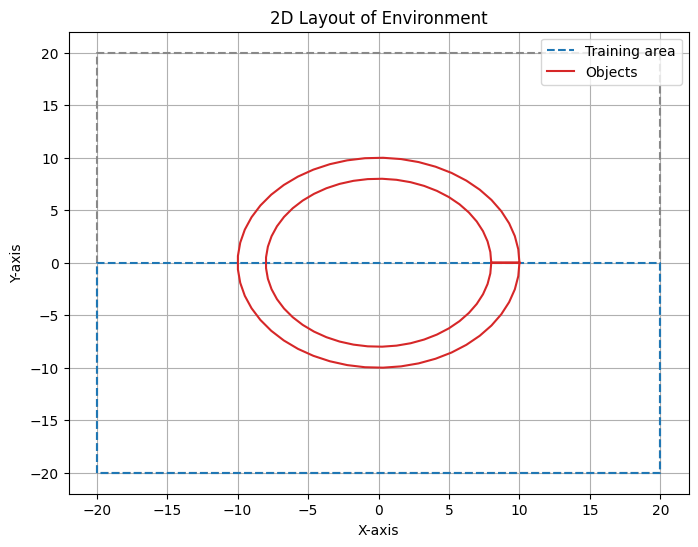

In [23]:
fig = builder.plot()

### Compile environment

In [24]:
geometry = builder.build()()

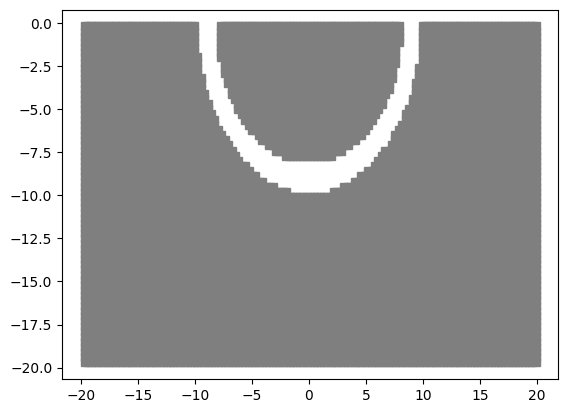

In [25]:
fig = geometry.training_space.plot()